# Оценка успешности компьютерных игр

Из открытых источников получены исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно выяснить закономерности, определяющие успешность игры. Нужно спланировать кампанию на год, следующий за последним в полученных данных. 

Данные представлены перечнем игр с указанием платформы, года выпуска, продажами в различных регионах, оценками пользователей и критиков и рейтингом по возрастным категориям.

**Цель проекта : выявить закономерности, влияющие на успешность продаж компьютерных игр и дать рекомендации магазину, на какие продукты делать ставку.**

**План** 

    1. Изучить данные 
    2. Подготовьте данные
        Заменить названия столбцов        
        Преобразовать данные в нужные типы 
        Обработать пропуски  
        Добавить расчетные данные
        Проверить дубликаты
    3. Провести исследовательский анализ данных
        Изучить выпуск игр в разные периоды
        Изучить данные о продажах по платформам 
        Выделить актуальный период  
        Выбрать несколько потенциально прибыльных платформ  
        Оцкнить влияние на продажи отзывов пользователей и критиков  
        Изучить распределение игр по жанрам 
    4. Провести анализ пользователей по регионам 
        Определить самые популярные платформы 
        Определить самые популярные жанры 
        Оценить влияние рейтинга ESRB на продажи в отдельном регионе 
    5. Проверить гипотезы
        Средние пользовательские рейтинги платформ Xbox One и PC одинаковые 
        Средние пользовательские рейтинги жанров Action и Sports разные  
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## Получение данных и изучение общей информации

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
display(games.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.describe(include=[object])

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


## Подготовка данных

### Изменение названий столбцов

In [6]:
games.columns = games.columns.str.lower()

**Привели названия столбцов к нижнему регистру.**

### Приведение типов данных

Нам нужно преобразовать год к целому. И избавиться от пропусков, которые невозможно заполнить. 

In [7]:
games.dropna(subset=['name'], inplace=True)

In [8]:
games['year_of_release'].isna().sum() 

269

In [9]:
def find_year_of_release(row): 
    if pd.isna(row['year_of_release']):
        year_of_release = round(games[(~games['year_of_release'].isna()) &
                                      (games['name'] == row['name'])]['year_of_release'].mean(),0)
        return year_of_release
    return row['year_of_release']

In [10]:
games['year_of_release'] = games.apply(find_year_of_release, axis=1)

In [11]:
games['year_of_release'].isna().sum() 

146

In [12]:
games.dropna(subset=['year_of_release'], inplace=True)

In [13]:
games['year_of_release'] = games['year_of_release'].astype(int)

In [14]:
memory_usage_before = games.memory_usage(deep= True).sum()

In [15]:
games['year_of_release'] = games['year_of_release'].astype(np.uint16)

In [16]:
memory_usage_difference = 1 - (games.memory_usage(deep= True).sum() / memory_usage_before)
print(f'{memory_usage_difference:.2%}')

1.68%


In [17]:
print(games['platform'].unique())
print(games['genre'].unique())

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']


**Cтроки с пустым именем и годом выпуска заполнить нечем, и их мало, можно удалить без ущерба данным. Год выпуска привели к целому типу. Проверили корретность заполнения данных о платформах и жанрах. Проблем нет.** 

### Обработка пропусков

Изучим пропуски. 

In [18]:
games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 13.])

In [19]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

У нас есть пустые значения оценок и значения 'tbd'. Либо оценок нет, либо недостаточно для формирования рейтинга. 
Не думаю, что мы можем рассчитать какие-либо значения, поэтому оставим их пустыми. 'tbd'тоже сделаем пустым и преобразуем тип к числам. 

In [20]:
games['user_score'] = games['user_score'].replace(to_replace ='tbd', value =np.NaN) 

In [21]:
games['user_score'] = games['user_score'].astype(np.float16)
games['user_score'] = games['user_score'].apply(lambda x: round(x, 1))

In [22]:
games['critic_score'] = games['critic_score'].astype(np.float16)

In [23]:
memory_usage_difference = 1 - (games.memory_usage(deep= True).sum() / memory_usage_before)
print(f'{memory_usage_difference:.2%}')

14.74%


**Теперь у нас только числовые оценки**

Так как мы не можем тожно определить рейтинг игру, заполним пустые значения неопределенным `Rating Pending`

In [24]:
games['rating'] = games['rating'].fillna('RP')

**Мы заполнили все пропуски**

### Добавление расчетных данных

In [25]:
games['total_sales'] = (games['na_sales'] + 
                        games['eu_sales'] + 
                        games['jp_sales'] +
                        games['other_sales']) 

**Посчитали суммарные продажи во всех регионах** 

In [26]:
games.duplicated().sum()

0

**Дубликатов нет**

In [27]:
display(games.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38


**Наши данные готовы к анализу**

## Исследовательский анализ

### Изучение выпуска игр в разные периоды

Посмотрим, сколько игр выпускалось в разные годы.

In [28]:
color = 'blue'
alpha=0.3
figsize = (15, 5)

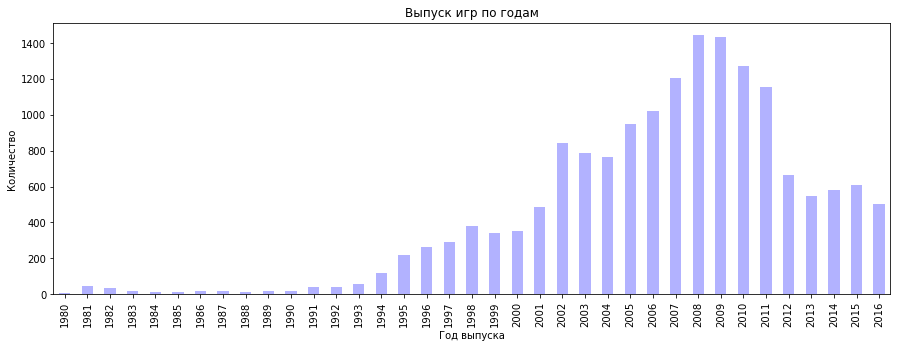

In [29]:
games_by_year = games.groupby('year_of_release')['name'].count()

games_by_year.plot(kind='bar',
                   alpha=alpha,
                   color=color,
                   figsize = figsize) 
plt.xlabel('Год выпуска')
plt.ylabel('Количество')    
plt.title('Выпуск игр по годам')  
plt.show()

Мы видим, что половину нашего периода выпуск игр очень маленький, поэтому можем ограничить наши данные.
Для начала возьмем с 2001 года

In [30]:
min_year = 2001

In [31]:
games = games[games['year_of_release'] >= min_year]

Изучим, как менялись продажи на разных платформах.

Выберем платформы с максимальными продажами.

In [32]:
def get_platforms_with_maximum_sales(colunm, count):
    platforms_with_maximum_sales = games.groupby('platform')[colunm].sum()
    platforms_with_maximum_sales = platforms_with_maximum_sales.sort_values(ascending = False)
    platforms_with_maximum_sales = platforms_with_maximum_sales.head(count) 
    display(pd.DataFrame(platforms_with_maximum_sales))
    return platforms_with_maximum_sales.index 

In [33]:
platforms = get_platforms_with_maximum_sales('total_sales', 10)

,total_sales
platform,
PS2,1207.99
X360,966.61
PS3,935.19
Wii,903.31
DS,804.26
PS4,314.14
GBA,313.66
PSP,293.57
3DS,258.53


In [34]:
platforms_with_maximum_sales = pd.merge(pd.DataFrame(platforms),
                                        games, 
                                        how='inner', 
                                        on=['platform'], 
                                        indicator = False) 
display(platforms_with_maximum_sales)

,platform,name,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,PS2,Grand Theft Auto: San Andreas,2004,Action,9.43,0.40,0.41,10.57,95.0,9.0,M,20.81
1,PS2,Grand Theft Auto: Vice City,2002,Action,8.41,5.49,0.47,1.78,95.0,8.7,M,16.15
2,PS2,Gran Turismo 3: A-Spec,2001,Racing,6.85,5.09,1.87,1.16,95.0,8.4,E,14.97
3,PS2,Grand Theft Auto III,2001,Action,6.99,4.51,0.30,1.30,97.0,8.5,M,13.10
4,PS2,Gran Turismo 4,2004,Racing,3.01,0.01,1.10,7.53,89.0,8.5,E,11.65
...,...,...,...,...,...,...,...,...,...,...,...,...
11790,XB,NHL 2K7,2006,Sports,0.01,0.00,0.00,0.00,78.0,NaN,E10+,0.01
11791,XB,Powerdrome,2004,Racing,0.01,0.00,0.00,0.00,69.0,7.0,T,0.01
11792,XB,"Crouching Tiger, Hidden Dragon",2003,Action,0.01,0.00,0.00,0.00,52.0,NaN,T,0.01
11793,XB,Super Bubble Pop,2002,Puzzle,0.01,0.00,0.00,0.00,42.0,NaN,E,0.01


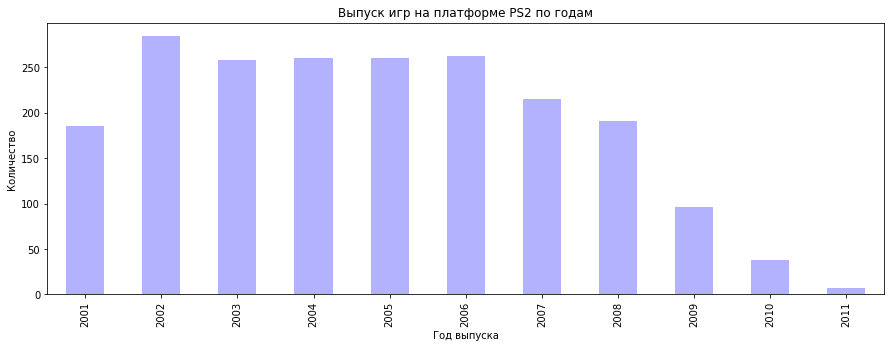

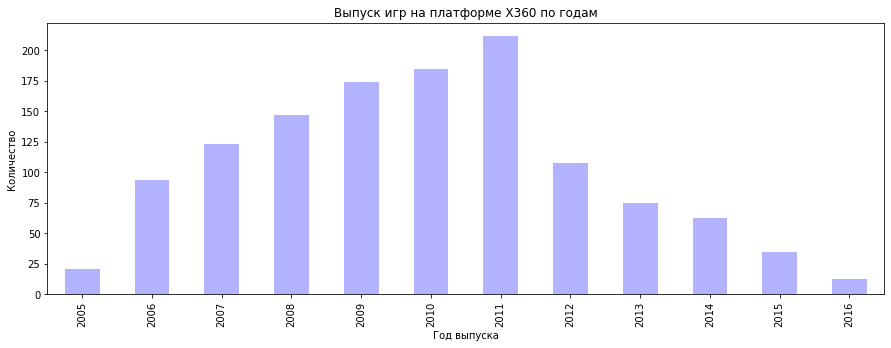

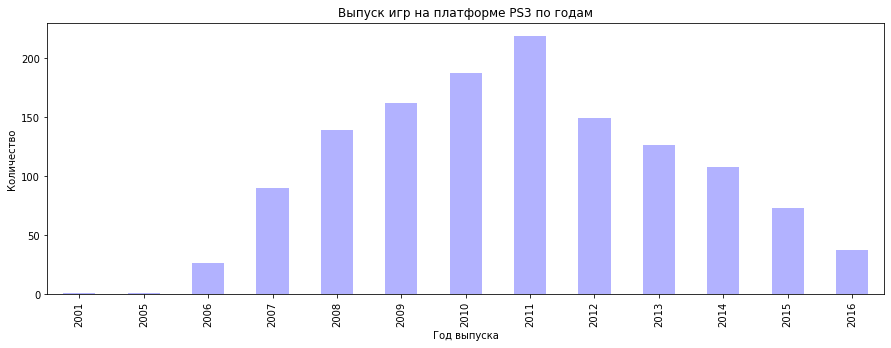

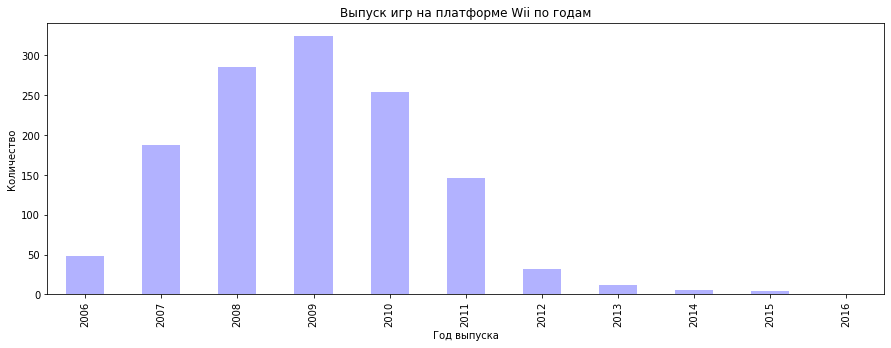

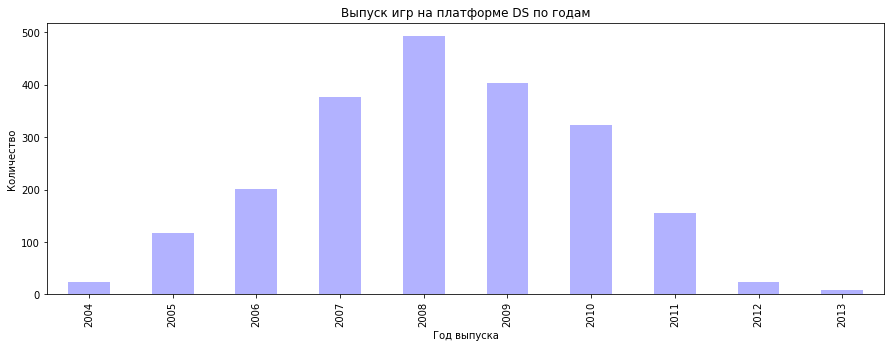

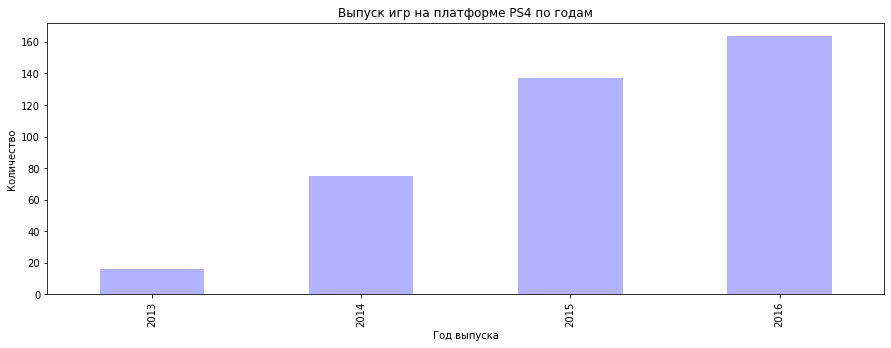

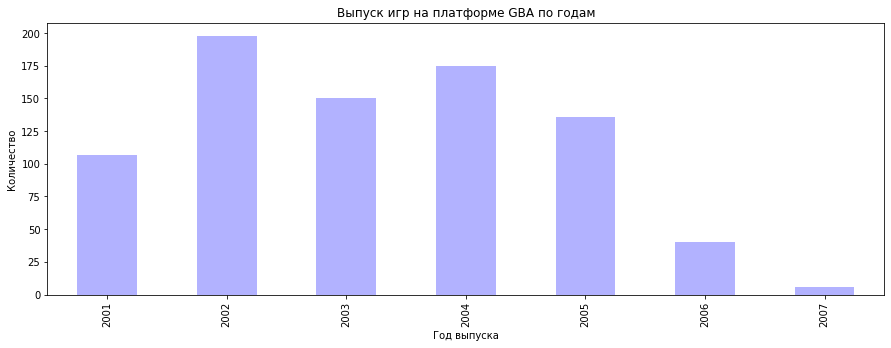

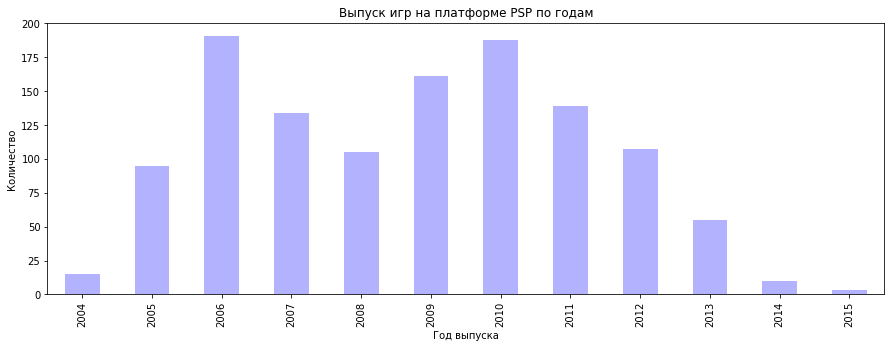

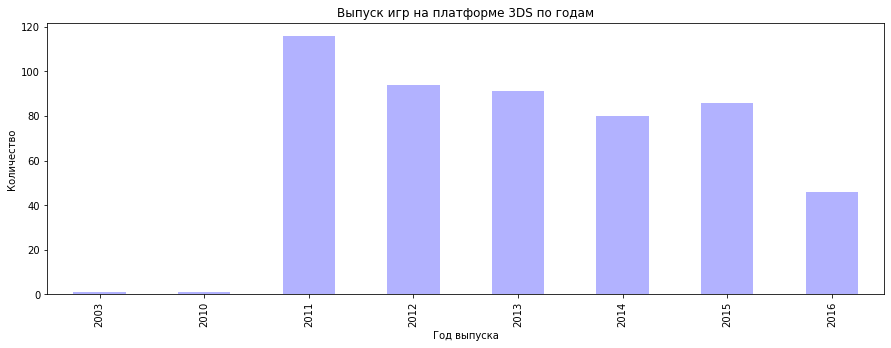

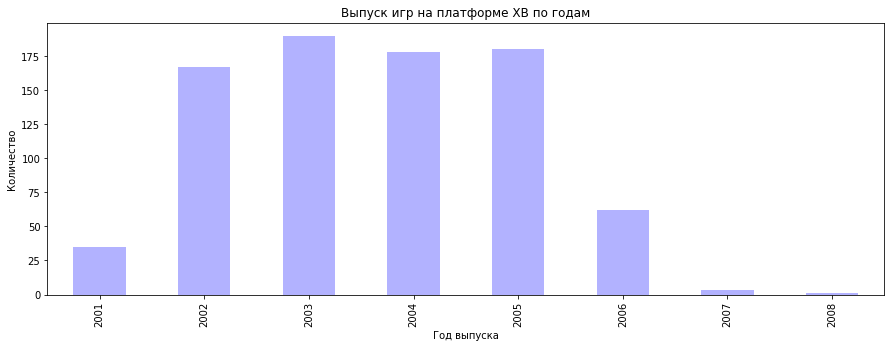

In [35]:
for platform in platforms:
    games_by_year = games[games['platform'] == platform].groupby('year_of_release')['name'].count()
    games_by_year.plot(kind='bar',
                   alpha=alpha,
                       color = color,
                   figsize = figsize) 
    
    plt.xlabel('Год выпуска')
    plt.ylabel('Количество')
    plt.title(f'Выпуск игр на платформе {platform} по годам')  

    plt.show()

**Мы видим, что "продолжительность жизни" платформы от 4 до 7 лет. Поэтому оставим для анализа последние 5 лет, этого будет достаточно**

In [36]:
min_year = 2012
games = games[games['year_of_release'] >= min_year]


### Изучение данные о продажах по платформам 

Сгруппируем данные по платформам

In [37]:
games_by_platform = games.pivot_table('total_sales', 
                                      index='year_of_release' , 
                                      columns='platform', 
                                      aggfunc='sum')  

platforms = list(games_by_platform)
print(platforms) 
games_by_platform.reset_index(inplace=True)

['3DS', 'DS', 'PC', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']


In [38]:
display(games_by_platform )

platform,year_of_release,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
0,2012,51.76,11.67,23.45,108.28,NaN,7.95,16.19,22.94,17.56,100.72,NaN
1,2013,56.57,1.54,12.66,113.25,25.99,3.38,10.59,8.59,21.65,88.58,18.96
2,2014,43.76,NaN,13.63,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
3,2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
4,2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


Text(0.5, 1.0, 'Продажи игр по годам')

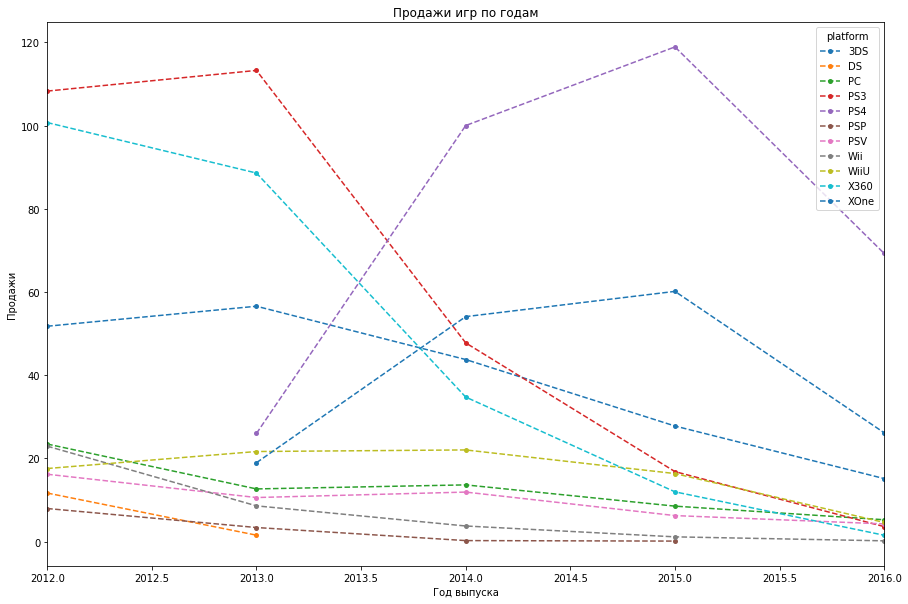

In [39]:
games_by_platform.plot(kind='line', 
                       x='year_of_release', 
                       y=platforms, 
                       figsize=(15,10),
                       ls = '--',
                       mew=2.0,
                       marker = '.')
plt.xlabel('Год выпуска')
plt.ylabel('Продажи')
plt.title(f'Продажи игр по годам')  

**Можем заметить, что продажи по всем платформам. которые существуют с 2012 года, кроме 3DS, упали до примеро одного уровня.
Платформы DS и PSP перестали существовать. Продажи на платформах XOne и PS4 росли до 2015 года, но за последний год тоже гачали падать. Но тем не менее, наиболее продаваемые за последнее время XOne, PS4 и 3DS**
 

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

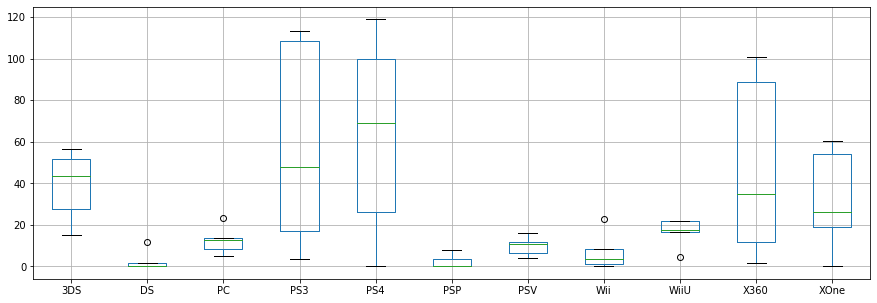

In [40]:
games_by_platform.fillna(0).boxplot(column= platforms,
                                    figsize = figsize )
plt.show()

**Мы видим, что более популярные платформы имеют и более широкий разброс. Тогда как менее популярные имеют более компактные данные, за исключением единичных выбросов.**

### Оценка влияние на продажи отзывов пользователей и критиков

Проанализируем влияние оценок на примере платформы PS4 


Коэффициент корреляции (Оценка критиков, Продажи)  =  0.41


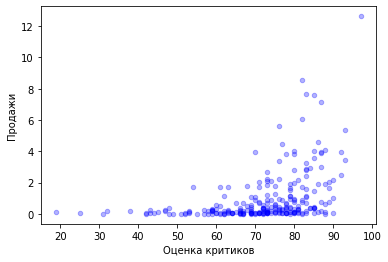

Коэффициент корреляции (Оценка пользователей, Продажи)  =  -0.03


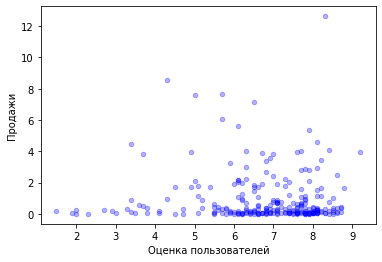

In [41]:
games_ps4 = games[(games['platform'] == 'PS4')]

def show_corr(data, colunms):
    corr_coeff = round(data[colunms[1]['name']].corr(data[colunms[0]['name']]),2)
    print(f"Коэффициент корреляции ({colunms[0]['caption']}, {colunms[1]['caption']})  = ", corr_coeff) 
    data.plot(kind = 'scatter',
                   x=colunms[0]['name'], 
                   y=colunms[1]['name'],
                   alpha=alpha,
                   color=color) 
    plt.xlabel(colunms[0]['caption'])
    plt.ylabel(colunms[1]['caption']) 
    plt.show()
    
show_corr(games_ps4, [{'name': 'critic_score', 'caption': 'Оценка критиков'},
                     {'name': 'total_sales', 'caption': 'Продажи'}]) 
show_corr(games_ps4, [{'name': 'user_score', 'caption': 'Оценка пользователей'},
                     {'name': 'total_sales', 'caption': 'Продажи'}])  
    
    

**Есть слабая положительная корреляция между продажами и оценками критиков. Тогда как с оценками пользователей продажи не коррелируют**

Коэффициент корреляции (Оценка критиков, Продажи)  =  0.31


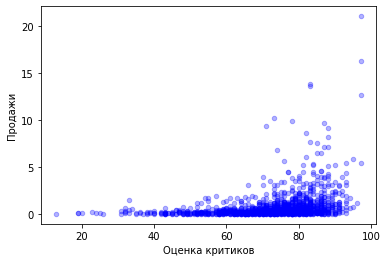

Коэффициент корреляции (Оценка пользователей, Продажи)  =  0.0


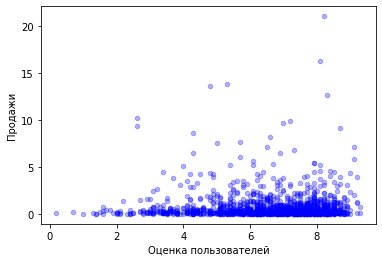

In [42]:
show_corr(games, [{'name': 'critic_score', 'caption': 'Оценка критиков'},
                     {'name': 'total_sales', 'caption': 'Продажи'}]) 
show_corr(games, [{'name': 'user_score', 'caption': 'Оценка пользователей'},
                     {'name': 'total_sales', 'caption': 'Продажи'}]) 

**Картина корреляций для всех платформ не отличается от наиболее популярной**


### Изучение распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам.

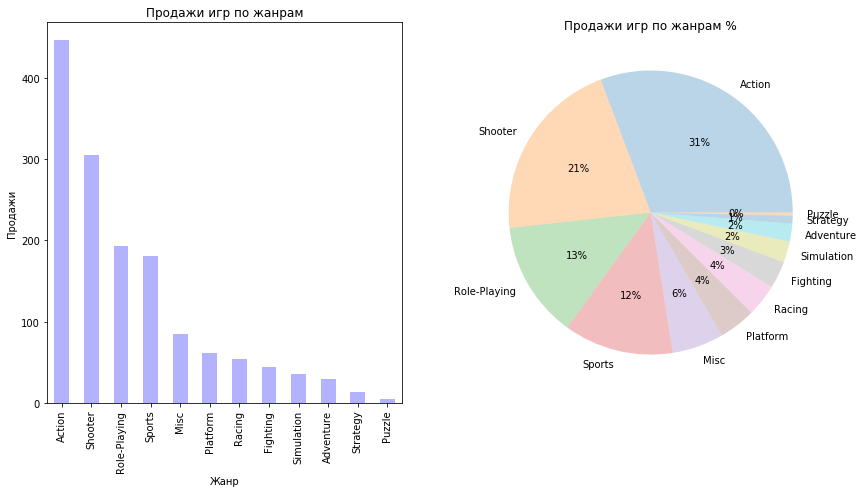

In [43]:
games_by_genre = games.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

plt.subplot(121)
games_by_genre.plot(kind='bar',
                   alpha=alpha,
                   color=color,
                   figsize=(14, 7)) 

plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.title('Продажи игр по жанрам')  
 
plt.subplot(122) 
games_by_genre.plot.pie(autopct='%1.f%%',  wedgeprops={'alpha':alpha }) 

plt.title('Продажи игр по жанрам %')  
plt.ylabel('') 
plt.show()

**В продажах лидируют жанры Action, Shooter, Role-Playing, Sports. Mist и Platgorm отличаются не так значительно, поэтому будем считать лидерами 4 жанра**

## Анализ пользователей по регионам


Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [44]:
get_platforms_with_maximum_sales('na_sales', 5)
get_platforms_with_maximum_sales('eu_sales', 5)
get_platforms_with_maximum_sales('jp_sales', 5)

,na_sales
platform,
X360,140.57
PS4,108.74
PS3,103.74
XOne,93.12
3DS,55.49


,eu_sales
platform,
PS4,141.09
PS3,107.27
X360,74.89
XOne,51.59
3DS,42.83


,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01


Index(['3DS', 'PS3', 'PSV', 'PS4', 'WiiU'], dtype='object', name='platform')

**Платформа 3DS популярна в Японии, и менее популярна в Европе и Америке. Вероятно, это связано тем, что у некоторых американских и европейских игроков прошивкой возникала проблема.**

**Платформа PS4 популярна везде, а вот популярность платформы X360 на американском рынке сами производители объясняли тем, что на рынке закончились доступные приставки PS4.** 

**Вероятно, продажа игр коррелирует с продажей приставок в каждом регионе.**

Изучим, влияет ли рейтинг ESRB на продажи в отдельном регионе?

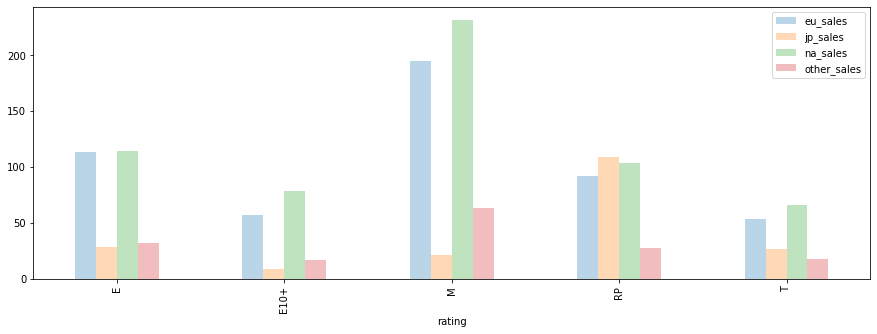

In [45]:
ratings = games['rating'].unique()
games_by_rating = games.pivot_table(['na_sales','eu_sales','jp_sales', 'other_sales'], 
                                      index='rating',  
                                      aggfunc='sum')  

 
games_by_rating.plot(kind='bar',
                   alpha=alpha, 
                   figsize = figsize) 

**Можно отметить, что что игры рейтинга `M` в Америке и Европе больше, чем игры, подходящие для всех `E`. А для детей и подростоков (`E10` и `T`) меньше. Мы получили довольно большую часть продаж в Японии с неопределенным рейтингом, что скорее всего связано с тем, что для продажи на территории Японии существует своя система рейтингов CERO.**
**Наших данных не хватает для того, чтобы говорить о продажах в зависимости от рейтинга на территории Японии**

## Проверка гипотез

Проверим гипотезы.

Рассчитаем средние пользовательские рейтинги игр на платформах Xbox One и PC4.

In [46]:
user_score_xbox = games[games['platform'] == 'XOne']['user_score'].dropna()
user_score_ps = games[games['platform'] == 'PS4']['user_score'].dropna()

In [47]:
def print_mesures(data, xlabel, tariff):
    '''печатает измерения.'''
    mean_value = data.mean()
    variance_estimate = np.var(data, ddof=1)
    standard_deviation = np.std(data)
    print(''.join(['Среднее значение (',
                   xlabel,
                   f') {tariff} :', 
                   ]),               
          f'{mean_value:.2f}') 
        
    print(''.join(['Дисперсия (',
                   xlabel,
                   f') {tariff} :', 
                   ]),               
          f'{variance_estimate:.2f}' )
        
    print(''.join(['Стандартное отклонение (',
                   xlabel,
                   f') {tariff} :', 
                   ]),               
          f'{standard_deviation:.2f}' )
        
    print()
def show_hist(data, bins, title, xlabel, range = None, orientation="vertical"): 
    ''' рисует гистограмму.'''   
    data.hist(bins = bins, 
              range = range,
              alpha=0.5,
              orientation = orientation, figsize = (10, 5)) 
    plt.xlabel(xlabel)
    plt.ylabel('Количество')    
    plt.title(title)    

Среднее значение (оценки пользователей) XOne : 6.52
Дисперсия (оценки пользователей) XOne : 1.91
Стандартное отклонение (оценки пользователей) XOne : 1.38

Среднее значение (оценки пользователей) PS4 : 6.75
Дисперсия (оценки пользователей) PS4 : 2.13
Стандартное отклонение (оценки пользователей) PS4 : 1.46



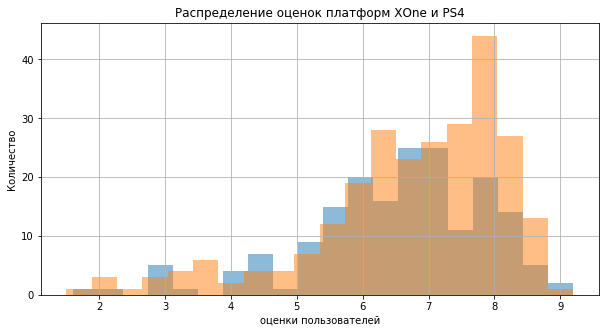

In [48]:
print_mesures(user_score_xbox, 'оценки пользователей', 'XOne')
print_mesures(user_score_ps, 'оценки пользователей', 'PS4')
show_hist(user_score_xbox, 20, '', '')  
        
show_hist(user_score_ps, 20, 'Распределение оценок платформ XOne и PS4', 'оценки пользователей')  
            

Мы видим, что средняя оценка пользователей игр для платформ XOne и PS4, близки. Проверим, можем ли мы утверждать, что они одинаковы.

 Для проверки используем двусторонний t - тест 

Сформулируем гипотезу:

- Нулевая гипотеза: средняя оценка пользователей платформы XOne и PS4 одинакова.


In [49]:
alpha = 0.05

results = st.ttest_ind(user_score_xbox, user_score_ps,equal_var=True)

print('p-значение:', round(results.pvalue, 4))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
 

p-значение: 0.1017
Не получилось отвергнуть нулевую гипотезу


**Можем предполагать, что средняя пользовательская оценка игр на платформах XOne и PS4 одинакова**

Рассчитаем средние пользовательские рейтинги игр жанров Action и Sports.

Среднее значение (оценки пользователей) Action : 6.83
Дисперсия (оценки пользователей) Action : 1.88
Стандартное отклонение (оценки пользователей) Action : 1.37

Среднее значение (оценки пользователей) Sports : 5.46
Дисперсия (оценки пользователей) Sports : 3.02
Стандартное отклонение (оценки пользователей) Sports : 1.73



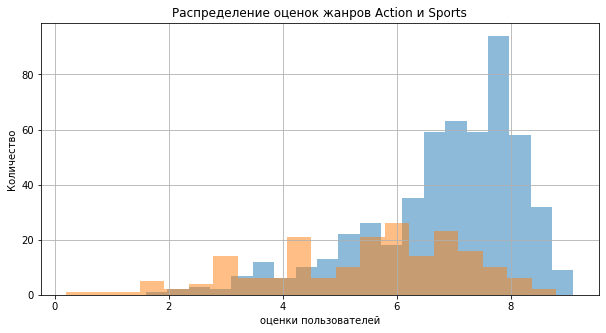

In [50]:
user_score_action = games[games['genre'] == 'Action']['user_score'].dropna()
user_score_sports = games[games['genre'] == 'Sports']['user_score'].dropna()
print_mesures(user_score_action, 'оценки пользователей', 'Action')
print_mesures(user_score_sports, 'оценки пользователей', 'Sports')
show_hist(user_score_action, 20, '', '')          
show_hist(user_score_sports, 20, 'Распределение оценок жанров Action и Sports', 'оценки пользователей')  

Мы видим, что средняя оценка пользователей игр жанра Action больше, чем Sports. Проверим, можем ли мы утверждать, что это действительно так.

Для проверки используем односторонний t - тест

Сформулируем гипотезы:

- Нулевая гипотеза: средняя оценка пользователей игр жанра Action и Sports.
- Альтернативная гипотеза: средняя оценка пользователей игр жанра Action больше, чем игр жанра Sports.

In [51]:
alpha = 0.05

results = st.ttest_ind(user_score_action, user_score_sports, equal_var=True)

print('p-значение:', results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (user_score_action.mean() > user_score_sports.mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.702819816133958e-27
Отвергаем нулевую гипотезу


**Мы можем предполагать, что игры жанра Action действительно оцениваются в среднем выше.**

## Общий вывод

Проанализировав данные, мы можем сделать следующие выводы: 

- Мы получили данные начиная с 1980 года, но анализ показал, что "срок жизни" игровой платформы около 5 лет, поэтому ограничили данные этиим сроком.

- Даже в течение такого срока что поулярность любой новой платфрмы растёт после выхода, и потом неизбежно падает. **В связи в эти можно порекомендовать магазину внимательно следить за появлением новых платформ, или новых версий платформ, которые были популярны.** 

- Кроме того, продажи игр по регионам связаны с распросранением устройств в этих регионах.

- В Европе и Америке больше продаётся игр для взрослых (рейтинг M). Но более поодробно изучит систему оценок в Японии и, возможно, сформировать более общий рейтинг, чтобы можно было опираться на эти данные.

- Мы отметили довольно слабую корреляцию продаж с оценкой критиками и практически никакой с оценкой пользователями. **Скорее всего, на это не стоит слишком обращать внимание.** 

- Обнаружены 4 самых популярных жанра:  Action, Shooter, Role-Playing, Sports. Их продажи сотавляет более 75% от всех. Причем самый популярный жанр Action занимает более 30% продаж. **Стоит делать ставку на игры этих жанров.**  